# Assignment 3 code

*Group 11*

Importstatements

In [6]:
# import required packages
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix


#setting the variable values:

# the size of the images in the PCAM dataset
IMAGE_SIZE = 96

#the pathway for the train+val data
path = 'C:\\Users\\20213314\\Documents\\BMT\\Jaar 3\\Project AI\\Data'
# save the model and weights
model_name = 'cnn_model_group_11'

Causing the image data to be read batch by batch, so only a single batch of images needs to be stored in memory at one time point

In [7]:
def get_pcam_generators(base_dir, train_batch_size=5, val_batch_size=32):
    """
    Uses the ImageDataGenerator function from the Keras API to return images in batches,
    train_gen for the training data and val_gen for the validation data.

    Args:
        base_dir (str): Base directory containing the dataset.
        train_batch_size (int): Batch size for training data. Default is 32.
        val_batch_size (int): Batch size for validation data. Default is 32.

    Returns:
        tuple: A tuple containing train_gen and val_gen, both are generators.
    """
    # Dataset parameters
    TRAIN_PATH = os.path.join(base_dir, 'train_new')#, 'train')
    VALID_PATH = os.path.join(base_dir, 'train+val', 'valid')
    RESCALING_FACTOR = 1./255
    
    # Instantiate data generators
    datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)

    # Generate data batches for training and validation sets
    train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size=train_batch_size,
                                            class_mode='binary')

    val_gen = datagen.flow_from_directory(VALID_PATH,
                                          target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                          batch_size=val_batch_size,
                                          class_mode='binary',
                                          shuffle=False)
    
    return train_gen, val_gen


Functions for creating and training the model

In [8]:
def get_model(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64):
    """
    Generates a convolutional neural network model with configurable parameters.

    Args:
        kernel_size (tuple): Tuple specifying the height and width of the 2D convolution window. Default is (3, 3).
        pool_size (tuple): Tuple specifying the factor by which to downscale in the pooling operation. Default is (4, 4).
        first_filters (int): Number of filters in the first convolutional layer. Default is 32.
        second_filters (int): Number of filters in the second convolutional layer. Default is 64.

    Returns:
        model: A Keras Sequential model.
    """
    # Build the model
    model = Sequential()

    # Add convolutional layers
    model.add(Conv2D(first_filters, kernel_size, activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(MaxPool2D(pool_size=pool_size))

    model.add(Conv2D(second_filters, kernel_size, activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=pool_size))

    # Flatten the output to feed into dense layers
    model.add(Flatten())

    # Add dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(SGD(learning_rate=0.01, momentum=0.95), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(),'accuracy'])

    return model

def train_model(model, train_gen, val_gen, weights_filepath, model_name, epochs=1):
    """
    Trains the provided model using the given data generators and saves the best weights.

    Args:
        model: The Keras Sequential model to train.
        train_gen: Generator for training data.
        val_gen: Generator for validation data.
        weights_filepath (str): Filepath to save the best weights.
        model_name (str): Name of the model, used for TensorBoard logging.
        epochs (int): Number of epochs to train the model for. Default is 1.

    Returns:
        history: History object containing training metrics.
    """

    model_json = model.to_json() # serialize model to JSON
    with open(model_name, 'w') as json_file:
        json_file.write(model_json)

    # Define callbacks
    checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    tensorboard = TensorBoard(log_dir=os.path.join('logs', model_name))
    callbacks_list = [checkpoint, tensorboard]

    # Train the model
    train_steps = train_gen.n // train_gen.batch_size
    val_steps = val_gen.n // val_gen.batch_size

    history = model.fit(train_gen, steps_per_epoch=train_steps, 
                        validation_data=val_gen,
                        validation_steps=val_steps,
                        epochs=epochs,
                        callbacks=callbacks_list)
    return history

def get_fcn_model(first_filters=32, second_filters=64, kernel_size=(3,3), pool_size=(4,4)):
    """
    Generates a fully convolutional neural network model with configurable parameters.

    Args:
        first_filters (int): Number of filters in the first convolutional layer. Default is 32.
        second_filters (int): Number of filters in the second convolutional layer. Default is 64.
        kernel_size (tuple): Tuple specifying the height and width of the 2D convolution window. Default is (3, 3).
        pool_size (tuple): Tuple specifying the factor by which to downscale in the pooling operation. Default is (4, 4).

    Returns:
        model: A Keras Sequential model.
    """
    # Build the model
    model = Sequential()

    # Add convolutional layers
    model.add(Conv2D(first_filters, kernel_size, activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(MaxPool2D(pool_size=pool_size))

    model.add(Conv2D(second_filters, kernel_size, activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=pool_size))

    model.add(Conv2D(second_filters, kernel_size, activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=pool_size))

    # Output layer
    model.add(Conv2D(1, kernel_size, activation='sigmoid', padding='same'))
    model.add(GlobalAveragePooling2D())

    # Compile the model
    model.compile(SGD(learning_rate=0.01, momentum=0.95), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(),'accuracy'])

    return model




Functions regarding ROC and AUC

In [9]:
def calculate_roc_and_auc(model, val_gen):
    """
    Performs the calculations necessary for the ROC curve and its AUC value.

    Args:
        model: The trained Keras model.
        val_gen: Generator for validation data.

    Returns:
        tuple: False positive rate, true positive rate, and AUC value.
    """
    # Predict probabilities for the validation set
    predictions = model.predict(val_gen)

    # Calculate the false positive rate (FPR) and true positive rate (TPR)
    fpr, tpr, thresholds = roc_curve(val_gen.labels, predictions)
    
    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Print classification report
    predictions[predictions <= 0.5] = 0.
    predictions[predictions > 0.5] = 1.
    print('Classification report:\n', classification_report(val_gen.labels, predictions))
    print('Confusion matrix:\n', confusion_matrix(val_gen.labels, predictions))
    
    return fpr, tpr, roc_auc

def plot_roc_curve(fpr, tpr, roc_auc, type='dense'):
    """
    Plot the ROC curve using the false positive rate, true positive rate, and AUC value.

    Args:
        fpr (array): False positive rate.
        tpr (array): True positive rate.
        roc_auc (float): Area under the ROC curve.
        type (str): Type of model to use ('dense' or 'conv'). Default is 'dense'. 
    """
    # Plot the ROC curve
    if type == 'dense':
        name_type ='connected'
    elif type == 'conv':
        name_type='convolutional'
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='gray', lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve of model with fully {} layers".format(name_type))
    plt.legend(loc="lower right")
    plt.show()

def calculate_and_plot_ROC_AUC(type='dense', model_name='my_model'):
    """
    Combine different functions to create and train the model, and to calculate and plot the ROC curve and AUC value.

    Args:
        type (str): Type of model to use ('dense' or 'conv'). Default is 'dense'.
        model_name (str): Name of the model.

    """
    # Get the model
    if type == 'dense':
        model = get_model()
    elif type == 'conv':
        model = get_fcn_model()

    print('Summary of model:')
    for layer in model.layers:
        print(layer.output_shape)

    # Get the data generators
    train_gen, val_gen = get_pcam_generators(path)
    
    model_filepath = model_name + '.json'
    weights_filepath = model_name + '_weights.hdf5'

    # Train the model
    train_model(model, train_gen, val_gen, weights_filepath, model_filepath, epochs=3)

    # Load the trained model weights
    model.load_weights(weights_filepath)

    # Evaluate the model
    score = model.evaluate(val_gen)
    print("Loss:", score[0])
    print("Accuracy:", score[1])
    
    # Calculate ROC and AUC
    fpr, tpr, roc_auc = calculate_roc_and_auc(model, val_gen)
    print("AUC:", roc_auc)
    
    # Plot ROC curve
    plot_roc_curve(fpr, tpr, roc_auc, type)



## Excercise 1

*Perform ROC curve analysis and computation of the AUC for your model.*

Summary of model:
(None, 96, 96, 32)
(None, 24, 24, 32)
(None, 24, 24, 64)
(None, 6, 6, 64)
(None, 2304)
(None, 64)
(None, 1)
Found 30 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Epoch 1/3
4/6 [===================>..........] - ETA: 0s - loss: 0.7008 - auc_2: 0.4350 - accuracy: 0.3500
Epoch 1: val_loss improved from inf to 0.69577, saving model to cnn_model_group_11_dense_weights.hdf5
6/6 [==============================] - 53s 11s/step - loss: 0.6981 - auc_2: 0.4422 - accuracy: 0.4000 - val_loss: 0.6958 - val_auc_2: 0.5795 - val_accuracy: 0.4999
Epoch 2/3
5/6 [========================>.....] - ETA: 0s - loss: 0.6922 - auc_2: 0.7051 - accuracy: 0.4800

C:\Users\20213314\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.69577
6/6 [==============================] - 13s 3s/step - loss: 0.6869 - auc_2: 0.7311 - accuracy: 0.5000 - val_loss: 0.6963 - val_auc_2: 0.6253 - val_accuracy: 0.4994
Epoch 3/3
6/6 [==============================] - ETA: 0s - loss: 0.6895 - auc_2: 0.5333 - accuracy: 0.5333
Epoch 3: val_loss improved from 0.69577 to 0.69496, saving model to cnn_model_group_11_dense_weights.hdf5
500/500 [==============================] - 13s 26ms/step - loss: 0.6950 - auc_2: 0.6262 - accuracy: 0.4989
Loss: 0.6949620246887207
Accuracy: 0.6262404322624207
500/500 [==============================] - 13s 26ms/step
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67      8000
           1       0.24      0.00      0.00      8000

    accuracy                           0.50     16000
   macro avg       0.37      0.50      0.33     16000
weighted avg       0.37      0.50      0.33     16000

Confusi

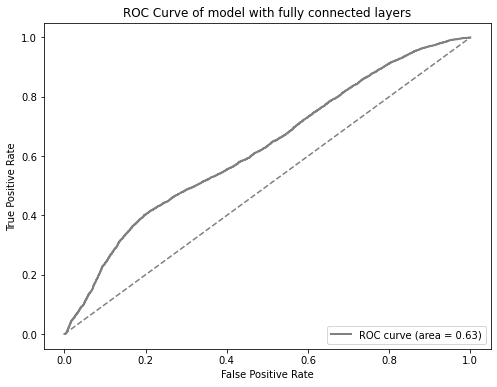

In [12]:
calculate_and_plot_ROC_AUC(model_name=model_name+'_dense')

## Excercise 2
*It is possible to construct a neural network model that is equivalent to the model above, however, only using convolutional layers (i.e. without using any fully connected or "dense" layers). Construct and train such a model.*

Summary of model:
(None, 96, 96, 32)
(None, 24, 24, 32)
(None, 24, 24, 64)
(None, 6, 6, 64)
(None, 6, 6, 64)
(None, 1, 1, 64)
(None, 1, 1, 1)
(None, 1)
Found 30 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Epoch 1/3
5/6 [========================>.....] - ETA: 0s - loss: 0.6954 - auc_3: 0.2981 - accuracy: 0.3600
Epoch 1: val_loss improved from inf to 0.69266, saving model to cnn_model_group_11_conv_weights.hdf5
6/6 [==============================] - 13s 3s/step - loss: 0.6953 - auc_3: 0.3444 - accuracy: 0.3667 - val_loss: 0.6927 - val_auc_3: 0.5936 - val_accuracy: 0.4999
Epoch 2/3
5/6 [========================>.....] - ETA: 0s - loss: 0.6955 - auc_3: 0.3409 - accuracy: 0.5600

C:\Users\20213314\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.69266
6/6 [==============================] - 13s 3s/step - loss: 0.7046 - auc_3: 0.3178 - accuracy: 0.5000 - val_loss: 0.6964 - val_auc_3: 0.6392 - val_accuracy: 0.5000
Epoch 3/3
6/6 [==============================] - ETA: 0s - loss: 0.7017 - auc_3: 0.3956 - accuracy: 0.5000
Epoch 3: val_loss improved from 0.69266 to 0.69195, saving model to cnn_model_group_11_conv_weights.hdf5
500/500 [==============================] - 13s 27ms/step - loss: 0.6920 - auc_3: 0.5987 - accuracy: 0.5640
Loss: 0.6919535994529724
Accuracy: 0.5987259149551392
500/500 [==============================] - 13s 27ms/step
Classification report:
               precision    recall  f1-score   support

           0       0.54      0.92      0.68      8000
           1       0.72      0.21      0.33      8000

    accuracy                           0.56     16000
   macro avg       0.63      0.56      0.50     16000
weighted avg       0.63      0.56      0.50     16000

Confusio

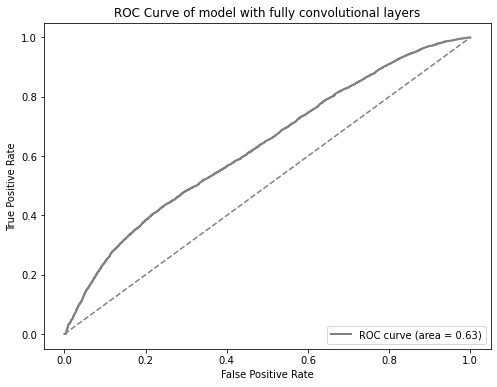

In [13]:
calculate_and_plot_ROC_AUC(type='conv', model_name=model_name+'_conv')

## Excercise 3
*Use the kaggle_submission.py file to prepare and submit results for evaluation to Kaggle. What is the result of the evaluation on the test set? How does it compare to the evaluation that you performed on the validation set?* 